In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import os
import PIL
from PIL import Image, ImageFont, ImageDraw
import numpy as np
import tqdm
import pandas as pd
import sys
import cv2
import torch
from tqdm import tqdm_notebook as tn

In [3]:
# diskPath = "/content/drive/MyDrive/"
# pathToDiplomaData = diskPath + "diplomaData/"
# pathToOutDir = diskPath + "diplomaData/binarizationGeneratedData"
# pathToOutDir = diskPath + "diplomaData/binarizationGeneratedData2"
# pathToGenerated = pathToOutDir + "/generated/"
# pathToGT = pathToOutDir + "/gt/"
# folderToDump = diskPath + "diplomaData/dumpsDetection"

In [4]:
diskPath = "D:/"
pathToDiplomaData = diskPath + "Data\Diploma/"
pathToOutDir = pathToDiplomaData + "generated/"
pathToTrain1 = pathToOutDir + "/Train1/"
pathToTrain2 = pathToOutDir + "/Train2/"
pathToTrain3 = pathToOutDir + "/Train3/"
pathToTest = pathToOutDir + "/Test/"
pathToValidation = pathToOutDir + "/Validate/"

# pathToTrain1NoAug = pathToOutDir + "/Train1noAug2/"
# pathToTrain3NoAug = pathToOutDir + "/Train3noAug2/"
# pathToValidationNoAug = pathToOutDir + "/ValidatenoAug2/"
# pathToTestNoAug = pathToOutDir + "/TestnoAug2/"

pathToGT = "gt/"
pathToGeneated = "generated/"
pathToDataList = "dataList.txt"

folderToDump = pathToDiplomaData + "dumps/"

In [5]:
os.makedirs(folderToDump, exist_ok=True)

In [6]:
# !mkdir "binarizationGeneratedData2"
# !cp "/content/drive/MyDrive/diplomaData/zip/1.zip" "./binarizationGeneratedData2/1.zip"
# !cp "/content/drive/MyDrive/diplomaData/zip/2.zip" "./binarizationGeneratedData2/2.zip"
# !cp "/content/drive/MyDrive/diplomaData/zip/3.zip" "./binarizationGeneratedData2/3.zip"
# !cp "/content/drive/MyDrive/diplomaData/zip/4.zip" "./binarizationGeneratedData2/4.zip"
# !cp "/content/drive/MyDrive/diplomaData/zip/5.zip" "./binarizationGeneratedData2/5.zip"
# !cp "/content/drive/MyDrive/diplomaData/zip/6.zip" "./binarizationGeneratedData2/6.zip"
# !cp "/content/drive/MyDrive/diplomaData/zip/7.zip" "./binarizationGeneratedData2/7.zip"

# !mkdir "binarizationGeneratedData2/data"
# !unzip "./binarizationGeneratedData2/1.zip" -d "binarizationGeneratedData2/data"
# !unzip "./binarizationGeneratedData2/2.zip" -d "binarizationGeneratedData2/data"
# !rm  "binarizationGeneratedData2/1.zip"
# !rm "binarizationGeneratedData2/2.zip"
# !unzip "./binarizationGeneratedData2/3.zip" -d "binarizationGeneratedData2/data"
# !unzip "./binarizationGeneratedData2/4.zip" -d "binarizationGeneratedData2/data"

# !rm  "binarizationGeneratedData2/3.zip"
# !rm "binarizationGeneratedData2/4.zip"

# !unzip "./binarizationGeneratedData2/5.zip" -d "binarizationGeneratedData2/data"
# !unzip "./binarizationGeneratedData2/6.zip" -d "binarizationGeneratedData2/data"
# !unzip "./binarizationGeneratedData2/7.zip" -d "binarizationGeneratedData2/data"
# !rm  "binarizationGeneratedData2/5.zip"
# !rm "binarizationGeneratedData2/6.zip"
# !rm  "binarizationGeneratedData2/7.zip"


In [7]:
# from google.colab import drive
# drive.mount('/content/drive')

In [8]:
# pathToOutDir = "./binarizationGeneratedData2/data/binarizationGeneratedData2"
# pathToGenerated = pathToOutDir + "/generated/"
# pathToGT = pathToOutDir + "/gt/"
# folderToDump = diskPath + "diplomaData/dumpsDetection"

In [9]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision

In [10]:
import json

In [11]:
imageSize = 800

In [12]:
class ResizeMinSide(object):
    def __init__(self, minSize=512, maxScaleFactor = 32):
        self.minSize = minSize
        self.maxScaleFactor = maxScaleFactor  #во скок раз сжимается картинка

    def __call__(self, img):
        w0,h0 = img.size
        w,h = img.size
        if h < w:
          h, w = self.minSize, w // h * self.minSize
          w = (w // 32 + 1) * 32
        else:
          h, w = h // w * self.minSize, self.minSize
          h = (h // 32 + 1) * 32
        h = int(h)
        w = int(w)
        h,w = (imageSize, imageSize)

        img = img.resize((w,h), PIL.Image.BILINEAR)
        newImg = Image.new(img.mode, (imageSize, imageSize), (255,255,255))
        newImg.paste(img, (0,0))

        assert(newImg.size == (imageSize,imageSize))
        ratio = (w/w0, h/h0)
        return newImg, ratio

    def __repr__(self):
        return "resizeMinSide"

class BinaryImageToTensor(object):
    def __init__(self):
      pass

    def __call__(self, img):
        return torch.from_numpy(np.array(img, dtype=np.long))

    def __repr__(self):
        return "binaryImageToTensor"

In [13]:
def getOuterRect(polygon, ratio=(1,1)):
  xMax, yMax,xMin, yMin = *polygon[0],*polygon[0]
  for point in polygon:
    x,y = point
    xMax, xMin, yMax, yMin = max(x, xMax), min(x,xMin), max(y,yMax), min(y, yMin)
  return(xMin*ratio[0], yMin*ratio[1], xMax*ratio[0], yMax*ratio[1])

In [14]:
allCharacters = {'\t': 95, '\n': 96, '\x0b': 98, '\x0c': 99, '\r': 97, ' ': 94, '!': 62, '"': 63, '#': 64, '$': 65, '%': 66, '&': 67, "'": 68, '(': 69, ')': 70, '*': 71, '+': 72, ',': 73, '-': 74, '.': 75, '/': 76, '0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, ':': 77, ';': 78, '<': 79, '=': 80, '>': 81, '?': 82, '@': 83, 'A': 36, 'B': 37, 'C': 38, 'D': 39, 'E': 40, 'F': 41, 'G': 42, 'H': 43, 'I': 44, 'J': 45, 'K': 46, 'L': 47, 'M': 48, 'N': 49, 'O': 50, 'P': 51, 'Q': 52, 'R': 53, 'S': 54, 'T': 55, 'U': 56, 'V': 57, 'W': 58, 'X': 59, 'Y': 60, 'Z': 61, '[': 84, '\\': 85, ']': 86, '^': 87, '_': 88, '`': 89, 'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15, 'g': 16, 'h': 17, 'i': 18, 'j': 19, 'k': 20, 'l': 21, 'm': 22, 'n': 23, 'o': 24, 'p': 25, 'q': 26, 'r': 27, 's': 28, 't': 29, 'u': 30, 'v': 31, 'w': 32, 'x': 33, 'y': 34, 'z': 35, '{': 90, '|': 91, '}': 92, '~': 93}

In [15]:
class BinarizationDataset(Dataset):
    def __init__(self, metadataFilePath, dataPath, transform=None, transfGt=None):
      """
      """
      self.dataPath = dataPath
      self.transform = transform
      self.transfGt = transfGt
      self.ratios = dict()
      self.gtDataAnatation = dict()
      with open(metadataFilePath, "r") as f:
        self.metadata = json.load(f)

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        #print(self.metadata[idx])
        distortedImage = PIL.Image.open(os.path.join(self.dataPath, self.metadata[idx]["distortedImage"]))
        distortedImage, ratio = ResizeMinSide()(distortedImage)
        gtImage = PIL.Image.open(os.path.join(self.dataPath, self.metadata[idx]["gtImage"]))
#         gtImage = gtImage.convert('RGBA')
        gtImage, ratio = ResizeMinSide()(gtImage)

        self.ratios[idx] = ratio
        
        
        gtImage = gtImage.convert('1')
        
        distortedImage = distortedImage.convert('RGB')

        if self.transfGt:
            gtImage = self.transfGt(gtImage)
        if self.transform:
            distortedImage = self.transform(distortedImage)

        # annotation = ""
        # gtData = dict()
        # boxes = []
        # labels = []
        # with open( os.path.join(self.dataPath, self.metadata[idx]["annotation"])) as f:
        #   annotation = json.load(f)
        # ratio = self.ratios[idx]
        # boxes.extend([getOuterRect(polygon, ratio) for polygon in annotation["wordRects"]])
        # labels.extend([1 for polygon in annotation["wordRects"]])
        
        # # for i in range(len(annotation["wordsCharactersRects"])):
        # #   boxes.extend([getOuterRect(polygon, ratio) for polygon in annotation["wordsCharactersRects"][i]])
        # #   #labels.extend([1 for character in annotation["words"][i]])
        # #   labels.extend([allCharacters[character] + 1 for character in annotation["words"][i]])
        # gtData["boxes"] = torch.from_numpy(np.array(boxes, dtype=np.float)).cuda()
        # gtData["labels"] = torch.from_numpy(np.array(labels, dtype=np.int)).cuda()

        # self.gtDataAnatation[idx] = gtData
        #возвращаем подготовленную картинку и название ее файла
        return distortedImage, gtImage, idx

    def getAnnotation(self, idx):
        annotation = ""
        with open( os.path.join(self.dataPath, self.metadata[idx]["annotation"])) as f:
          annotation = json.load(f)
        return annotation
    def getOriginalDistortedImage(self, idx):
      distortedImage = PIL.Image.open(os.path.join(self.dataPath, self.metadata[idx]["distortedImage"]))
      distortedImage,_ = ResizeMinSide()(distortedImage)
      return distortedImage

    def getBboxesAndSymbolclasses(self, indices):
      data = []
      for i in indices:
        idx = i.item()
        annotation = ""
        gtData = dict()
        boxes = []
        labels = []
        with open( os.path.join(self.dataPath, self.metadata[idx]["annotation"])) as f:
          annotation = json.load(f)
        ratio = self.ratios[idx]
        boxes.extend([getOuterRect(polygon, ratio) for polygon in annotation["wordRects"]])
        labels.extend([1 for polygon in annotation["wordRects"]])
        
        # for i in range(len(annotation["wordsCharactersRects"])):
        #   boxes.extend([getOuterRect(polygon, ratio) for polygon in annotation["wordsCharactersRects"][i]])
        #   #labels.extend([1 for character in annotation["words"][i]])
        #   labels.extend([allCharacters[character] + 1 for character in annotation["words"][i]])
        gtData["boxes"] = torch.from_numpy(np.array(boxes, dtype=np.float)).cuda()
        gtData["labels"] = torch.from_numpy(np.array(labels, dtype=np.int)).cuda()
        data.append(gtData)
      return data

In [16]:
# datasetTrain1 = BinarizationDataset(pathToTrain1 + pathToDataList, pathToTrain3)
# datasetValidation = BinarizationDataset(pathToValidation + pathToDataList, pathToTrain1)

In [17]:
pathToTrain1 + pathToDataList

'D:/Data\\Diploma/generated//Train1/dataList.txt'

In [18]:
def getAnnotationImage(image, annotation):
    img = image.copy()
    ind = 0
    for rotated, characters in zip(annotation["wordRects"], annotation["wordsCharactersRects"]):
        d = ImageDraw.Draw(img)
        ind = ind + 1
        d.line((rotated[0][0], rotated[0][1], rotated[1][0], rotated[1][1]), fill=(255,0,255), width=2)
        d.line((rotated[1][0], rotated[1][1], rotated[2][0], rotated[2][1]), fill=(255,0,255), width=2)
        d.line((rotated[2][0], rotated[2][1], rotated[3][0], rotated[3][1]), fill=(255,0,255), width=2)
        d.line((rotated[3][0], rotated[3][1], rotated[0][0], rotated[0][1]), fill=(255,0,255), width=2)

        for c in characters:
            d.line((c[0][0], c[0][1], c[1][0], c[1][1]), fill=(255,0,255), width=2)
            d.line((c[1][0], c[1][1], c[2][0], c[2][1]), fill=(255,0,255), width=2)
            d.line((c[2][0], c[2][1], c[3][0], c[3][1]), fill=(255,0,255), width=2)
            d.line((c[3][0], c[3][1], c[0][0], c[0][1]), fill=(255,0,255), width=2)
    return img

In [19]:
# distortedImage, _, ind = dataset.__getitem__(0)
# annotation = dataset.getAnnotation(0)
# getAnnotationImage(distortedImage, annotation)

In [20]:
from torch import nn
import torch
import torch.nn.functional as F

In [21]:
# from torchsummary import summary
#backBone = torchvision.models.mobilenet_v3_large(True, True) 
#summary(nn.Sequential(*list(backBone.features)[:17]), (3, 1024, 758))

In [22]:
import random
import numpy as np
import torch.backends.cudnn as cudnn

def set_random_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    random.seed(seed)
    np.random.seed(seed)
    
def prepare_cudnn(deterministic=True, benchmark=False):
    if torch.cuda.is_available():
        # CuDNN reproducibility
        # https://pytorch.org/docs/stable/notes/randomness.html#cudnn
        cudnn.deterministic = deterministic

        # https://discuss.pytorch.org/t/how-should-i-disable-using-cudnn-in-my-code/38053/4
        cudnn.benchmark = benchmark
        
def set_deterministic_behaviour(seed=42):
    set_random_seed(seed)
    prepare_cudnn(deterministic=True, benchmark=False)

In [23]:
# сделаем предобработку изображения, которая была применена при обучении
import torchvision
set_deterministic_behaviour

transf = torchvision.transforms.Compose([
                                #ResizeMinSide(),
                                torchvision.transforms.PILToTensor(),
                                transforms.ConvertImageDtype(torch.float),
                                #transforms.Normalize(mean=[0.485], std=[0.229]) 
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])                             
                                ])
transfGt = torchvision.transforms.Compose([
                                #ResizeMinSide(),
                                BinaryImageToTensor()
                                ])
#собственно сам загрузчик
train_dataset = BinarizationDataset(pathToTrain3 + pathToDataList, pathToTrain3, transf, transfGt)
valid_dataset = BinarizationDataset(pathToValidation + pathToDataList, pathToValidation, transf, transfGt)
test_dataset = BinarizationDataset(pathToTest + pathToDataList, pathToTest, transf, transfGt)

train_dataLoader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=4,
                                          shuffle=True,
                                          num_workers=0)
valid_dataLoader = torch.utils.data.DataLoader(valid_dataset,
                                          batch_size=4,
                                          shuffle=True,
                                          num_workers=0)

test_daraLoader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=1,
                                          shuffle=True,
                                          num_workers=0)

                                

In [24]:
for a, b, c in train_dataLoader:
  break

<ipython-input-12-5733ceb21e19>:35: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return torch.from_numpy(np.array(img, dtype=np.long))


In [25]:
c

tensor([5312, 4117, 2164, 2376])

In [26]:
class Upsample2(nn.Module):
  def __init__(self, numFeatures):
    super(Upsample2, self).__init__()
    self.upsample = nn.Sequential(
        nn.Upsample(scale_factor=2, mode='bilinear'),
        nn.Conv2d(numFeatures, numFeatures // 2, 1)
    )
  
  def forward(self, x):
    return self.upsample(x)

In [27]:
from torch import nn
import torch
import torch.nn.functional as F

class Binarizer(nn.Module):
  def __init__(self, inputHeight=512, inputWidth=512):

    super(Binarizer, self).__init__()    
    backbone = torchvision.models.mobilenet_v3_large(True, True)
    self.backbonep1 = nn.Sequential(*list(backbone.features)[:2])
    self.backbonep2 = nn.Sequential(*list(backbone.features)[2:7])
    self.backbonep3 = nn.Sequential(*list(backbone.features)[7:13])
    self.backbonep4 = nn.Sequential(*list(backbone.features)[13:17])

    featuresCount0 = 960
    self.upsample1 = nn.Sequential(
        Upsample2(featuresCount0),
    )
    featuresCount1 = featuresCount0 // 2 + 112# = 592 
    self.upsample2 = nn.Sequential(
        Upsample2(featuresCount1),
        nn.ReLU()
    )
    featuresCount2 = featuresCount1 // 2 + 40# = 336
    self.upsample3 = nn.Sequential(
        nn.BatchNorm2d(featuresCount2),
        Upsample2(featuresCount2),
        Upsample2(featuresCount2 // 2),
        nn.ReLU(),
    )
    featuresCount3 = featuresCount2 // 4 + 16# = 100
    self.mergedFeature = nn.Sequential(
        nn.BatchNorm2d(featuresCount3),
        Upsample2(featuresCount3),
        nn.Conv2d(featuresCount3 // 2, featuresCount3 // 2, 1),
        nn.ReLU(),
        nn.Conv2d(featuresCount3 // 2, featuresCount3 // 4, 1)
        )
    
    featuresCount4 = featuresCount3 // 4
    #25

    self.binarization1 = nn.Sequential(
        nn.Conv2d(featuresCount4, 16, 1),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Conv2d(16, 16, 1),
        nn.Conv2d(16, 8, 1),
        nn.ReLU(),
        nn.BatchNorm2d(8),
        nn.Conv2d(8, 2, 1),
    )   
    self.binarization2 = nn.Sequential(
        nn.Conv2d(featuresCount2//4, 16, 1),
        Upsample2(16),
        nn.Conv2d(8, 4, 1),
        nn.ReLU(),
        nn.BatchNorm2d(4),
        nn.Conv2d(4, 2, 1),
    )   
        
    self.binarization3 = nn.Sequential(
        nn.Conv2d(featuresCount1//2, 32, 1),
        Upsample2(32),
        Upsample2(16),
        nn.BatchNorm2d(8),
        Upsample2(8),
        nn.ReLU(),
        nn.BatchNorm2d(4),
        nn.Conv2d(4, 2, 1),
    )  
    
#     self.combinedBin = nn.Sequential(
#         nn.Conv2d(2 * 3, 6, 3, padding=1),
#         nn.ReLU(),
#         nn.BatchNorm2d(6),
#         nn.Conv2d(6, 6, 3, padding=1),
#         nn.ReLU(),
#         nn.BatchNorm2d(6),
#         nn.Conv2d(6, 2, 3, padding=1),
#     )

  def forward(self, x):
    l1_features = self.backbonep1(x)
    l2_features = self.backbonep2(l1_features)
    l3_features = self.backbonep3(l2_features)
    l4_features = self.backbonep4(l3_features)
    comb1_features = self.upsample1(l4_features)
    comb2_features = self.upsample2(torch.cat([comb1_features, l3_features], dim=1))
    comb3_features = self.upsample3(torch.cat([comb2_features, l2_features], dim=1))
    combined_features = self.mergedFeature(torch.cat([comb3_features, l1_features], dim=1))
    #предсказываем на разных уровнях
    bin_pred1 = self.binarization1(combined_features)#.transpose(1,2).transpose(2,3)#B2HW
   
    bin_pred2 = self.binarization2(comb3_features)
    bin_pred3 = self.binarization3(comb2_features)
    #bin_pred = self.combinedBin(torch.cat([bin_pred1, bin_pred2,bin_pred3], dim=1))
    bin_pred = bin_pred1 + bin_pred2 + bin_pred3
    #print()
    prob  = nn.functional.softmax(bin_pred, dim=1)
    top_p, top_class = prob.topk(1, dim = 1)
    return bin_pred, top_class, combined_features

In [28]:
from torchsummary import summary

In [29]:
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
from tqdm import tqdm_notebook as tn
import json
from torch.autograd import Variable

In [30]:
def diceCoeffv2(pred, gt, eps=1e-5, activation='sigmoid'):
    r""" computational formula：
        dice = (2 * tp) / (2 * tp + fp + fn)
    """
 
    if activation is None or activation == "none":
        activation_fn = lambda x: x
    elif activation == "sigmoid":
        activation_fn = nn.Sigmoid()
    elif activation == "softmax2d":
        activation_fn = nn.Softmax2d()
    else:
        assert(false)
 
    pred = activation_fn(pred)
 
    N = gt.size(0)
    pred_flat = pred.view(N, -1)
    gt_flat = gt.view(N, -1)
 
    tp = torch.sum(gt_flat * pred_flat, dim=1)
    fp = torch.sum(pred_flat, dim=1) - tp
    fn = torch.sum(gt_flat, dim=1) - tp
    loss = (2 * tp + eps) / (2 * tp + fp + fn + eps)

    return loss.sum() / N

class DiceLoss(nn.Module):
    __name__ = 'dice_loss'
 
    def __init__(self, activation='sigmoid'):
        super(DiceLoss, self).__init__()
        self.activation = activation
 
    def forward(self, y_pr, y_gt):
        return 1 - diceCoeffv2(y_pr, y_gt, activation=self.activation)


class FocalLoss(nn.Module):
    def __init__(self, gamma=1, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [31]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

def generateFastRCNNModel(backbone):
  backbone.out_channels = 960

  # let's make the RPN generate 5 x 3 anchors per spatial
  # location, with 5 different sizes and 3 different aspect
  # ratios. We have a Tuple[Tuple[int]] because each feature
  # map could potentially have different sizes and
  # aspect ratios
  anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                    aspect_ratios=((0.5, 1.0, 2.0),))

  # let's define what are the feature maps that we will
  # use to perform the region of interest cropping, as well as
  # the size of the crop after rescaling.
  # if your backbone returns a Tensor, featmap_names is expected to
  # be [0]. More generally, the backbone should return an
  # OrderedDict[Tensor], and in featmap_names you can choose which
  # feature maps to use.
  roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                  output_size=7,
                                                  sampling_ratio=2)

  # put the pieces together inside a FasterRCNN model
  model = FasterRCNN(backbone,
                    #num_classes=1#len(allCharacters) + 1, #2,#len(allCharacters), #0 for background
                    num_classes= 2,#len(allCharacters), #0 for background
                    rpn_anchor_generator=anchor_generator,
                    box_roi_pool=roi_pooler)
  
  return model

In [32]:
def plotImageBboxes(img, bboxes):
    bboxes = bboxes.detach().cpu().numpy()
    img = img.copy()
    ind = 0
    for bbox in bboxes:
        d = ImageDraw.Draw(img)
        d.rectangle([(bbox[0],bbox[1]),(bbox[2],bbox[3])], outline ="green")
    return img

In [33]:
# syntheticDataset.__getitem__(0)
# bb = syntheticDataset.getBboxesAndSymbolclasses(torch.from_numpy( np.array([0])))[0]
# plotImageBboxes(syntheticDataset.getOriginalDistortedImage(0), bb["boxes"])

In [34]:
def trainDetectionFreezed(train_dataloader, syntheticDataset, net, detectionNet, optimizer, loss_ce, loss_dice, epoch_num, w_decay=0, learningRate=0.001):
    set_deterministic_behaviour()
    net.cuda()
    detectionNet.cuda()

    detectionNet.train()
    net.train()

    for param in net.parameters():
      param.requires_grad = False


    lr = learningRate
    test_losses = []
    train_losses = []
    test_acces = []
    for epoch in range(epoch_num):
        if epoch in [0, 7, 11]:
        # if epoch in [0, 35, 80]:
            lr = lr / 10
            params = [p for p in detectionNet.parameters() if p.requires_grad]
            optimizer = torch.optim.Adam(params, weight_decay=w_decay, lr=lr)

        net.train()
        train_loss = []
        progress = tn(train_dataloader)
        for i, data in enumerate(progress):
          distortedImage, gtImage, imageIndices = data
          distortedImage = distortedImage.cuda()
          gtImage = gtImage.cuda()

          optimizer.zero_grad()
          #predBoxes, predLabels,
          gtData = syntheticDataset.getBboxesAndSymbolclasses(imageIndices)
          detectionLossesDict = detectionNet(distortedImage, gtData)
          detectionLoss = detectionLossesDict["loss_box_reg"]+ detectionLossesDict["loss_classifier"] \
            + detectionLossesDict["loss_objectness"] +  detectionLossesDict["loss_rpn_box_reg"]

          loss = detectionLoss
          loss.backward()
          optimizer.step()
          
          train_loss.append(loss.item())
          
          progress.set_description("loss: %f.3" % np.mean(train_loss) )
        # 
          #print(binMap.shape)
          #print(gtImage.shape)
          if i % 10 == 0:
            #print(gtData[0])
            detectionNet.eval()
            detectionLossesDict = detectionNet([distortedImage[0]], [gtData[0]])[0]
            img = plotImageBboxes(syntheticDataset.getOriginalDistortedImage(imageIndices[0].item()), gtData[0]["boxes"])
            plt.imshow(np.array(img))
            plt.show()
            print(len(gtData[0]["boxes"]))
            print(len(detectionLossesDict["boxes"]))
            img = plotImageBboxes(syntheticDataset.getOriginalDistortedImage(imageIndices[0].item()), detectionLossesDict["boxes"])
            plt.imshow(np.array(img))
            plt.show()

            detectionNet.train()
             # del(x)
            # del(y)
            # del(out)
            # del(loss)

            
        train_losses.append(np.mean(train_loss))
        
        plt.title("epoch:{} train loss: {}".format(epoch, train_losses[-1]))
        display.clear_output(wait=True)
        plt.plot(train_losses, label="train")
        plt.legend()
        plt.show()
        
        os.makedirs(folderToDump + "_DetectionFreeze"+"/", exist_ok=True)
        torch.save(detectionNet.state_dict(), folderToDump + "_DetectionFreeze"+"/" + str(epoch)+"detectionNet")
        logs = dict()
        logs["trainLoss"] = train_loss
        
        with open( folderToDump + "_DetectionFreeze" + "/log" + str(epoch) + ".txt", "w" ) as f:
          json.dump(logs, f)

        

    for param in net.parameters():
      param.requires_grad = True

In [35]:
def trainDetection(train_dataloader, syntheticDataset, net, detectionNet, optimizer, loss_ce, loss_dice, epoch_num, w_decay=0, learningRate=0.001, startEpoch=0):
    set_deterministic_behaviour()
    net.cuda()
    detectionNet.cuda()

    detectionNet.train()
    net.train()
    for param in net.parameters():
          param.requires_grad = True

    lr = learningRate
    test_losses = []
    train_losses = []
    test_acces = []
    for epoch in range(startEpoch+1, epoch_num):
        if epoch in [0, 7, 11]:
        # if epoch in [0, 35, 80]:
            lr = lr / 10
            optimizer = torch.optim.Adam(list(net.parameters()) + list(detectionNet.parameters()), weight_decay=w_decay, lr=lr)

        net.train()
        train_loss = []
        progress = tn(train_dataloader)
        for i, data in enumerate(progress):
            distortedImage, gtImage, imageIndices = data
            distortedImage = distortedImage.cuda()
            gtImage = gtImage.cuda()

            optimizer.zero_grad()
            binLogits, binClasses, _ = net(distortedImage)
            binClasses = binClasses.squeeze(1)
            lossEntropy = loss_ce(binLogits, gtImage.squeeze(1))
            lossDice = loss_dice(binClasses, gtImage.squeeze(1))
            #predBoxes, predLabels,
            gtData = syntheticDataset.getBboxesAndSymbolclasses(imageIndices)
            detectionLossesDict = detectionNet(distortedImage, gtData)
            detectionLoss = detectionLossesDict["loss_box_reg"] + 0.01 * detectionLossesDict["loss_classifier"] \
              + 0.01 * detectionLossesDict["loss_objectness"] + detectionLossesDict["loss_rpn_box_reg"]

            loss = 0.5 * lossEntropy + lossDice + 0.5 * detectionLoss
            #print(binMap.shape)
            #print(gtImage.shape)
            if i % 1 == 0:
              plt.figure(figsize=(10,10))
              plt.imshow(binClasses[0].detach().cpu().squeeze(0).numpy(), cmap="binary")
              plt.show()
              plt.figure(figsize=(10,10))
              plt.imshow(gtImage[0].detach().cpu().squeeze(0).numpy(), cmap="binary")
              plt.show()
              detectionNet.eval()
              detectionLossesDict = detectionNet([distortedImage[0]], [gtData[0]])[0]
              print("image")
              plt.figure(figsize=(10,10))
              img = plotImageBboxes(syntheticDataset.getOriginalDistortedImage(imageIndices[0].item()), gtData[0]["boxes"])
              plt.imshow(np.array(img))
              plt.show()
              plt.figure(figsize=(10,10))
              img = plotImageBboxes(syntheticDataset.getOriginalDistortedImage(imageIndices[0].item()), detectionLossesDict["boxes"])
              plt.imshow(np.array(img))
              plt.show()

              detectionNet.train()
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
            
            progress.set_description("loss: %f.3" % np.mean(train_loss) )
            # del(x)
            # del(y)
            # del(out)
            # del(loss)

            
        train_losses.append(np.mean(train_loss))
        
        plt.title("epoch:{} train loss: {}".format(epoch, train_losses[-1]))
        display.clear_output(wait=True)
        plt.plot(train_losses, label="train")
        plt.legend()
        plt.show()
        
        os.makedirs(folderToDump, exist_ok=True)
        torch.save(net.state_dict(), folderToDump+"/" + str(epoch))
        torch.save(detectionNet.state_dict(), folderToDump + "/" + str(epoch)+"detectionNet")
        logs = dict()
        logs["trainLoss"] = train_loss
        
        with open( folderToDump + "/log" + str(epoch) + ".txt", "w" ) as f:
          json.dump(logs, f)



In [36]:
SMOOTH = 1e-6
def countIOU(mask1, mask2):
    intersection = (mask1 * mask2).sum()
    union = mask1.sum() + mask2.sum()
    return intersection / (union + SMOOTH)

In [37]:
def processBatch(dataloader, net, loss_ce, loss_dice, shouldPrint, shouldTrain,  optimizer= None, coefs = {"Dice":1, "CE":0.5}):
    print("shouldTrain " + str(shouldTrain) + " shouldPrint " + str(shouldPrint))
    train_loss = []
    ious = []
    progress = tn(dataloader)
    for i, data in enumerate(progress):
      distortedImage, gtImage, annotation = data
      distortedImage = distortedImage.cuda()
      gtImage = gtImage.cuda()
      if shouldTrain:
        optimizer.zero_grad()
      if shouldTrain:
          binLogits, binClasses, _ = net(distortedImage)
      else:
        with torch.no_grad():
          binLogits, binClasses, _ = net(distortedImage)
            
      binClasses = binClasses.squeeze()
      lossEntropy = loss_ce(binLogits, gtImage.squeeze().long())
      lossDice = loss_dice(binClasses, gtImage.squeeze())
    
    

      loss = coefs["CE"] * lossEntropy + coefs["Dice"] * lossDice
      if shouldPrint and i % 10 == 0:
        plt.imshow(binClasses[0].detach().cpu().squeeze().numpy(), cmap="binary")
        plt.show()
        plt.imshow(gtImage[0].detach().cpu().squeeze().numpy(), cmap="binary")
        plt.show()
      if shouldTrain:
        loss.backward()
        optimizer.step()

      train_loss.append(loss.item())
      if not shouldTrain:
          iou = countIOU(binClasses[0].detach().cpu().squeeze().numpy(), gtImage[0].detach().cpu().squeeze().numpy())
          ious.append(iou)
            
      
    

      del binLogits
      del binClasses
      del lossEntropy
      del lossDice
      del loss
      progress.set_description("loss: %f.3" % np.mean(train_loss) )
    
      #break
    metrics = dict()
    metrics["train"] = np.mean(train_loss)
    if not shouldTrain:
        metrics["iou"] = np.mean(ious)
    return metrics

In [38]:
def freezeBackBone(net):
    for param in net.backbonep1.parameters():
        param.requires_grad = False
    for param in net.backbonep2.parameters():
      param.requires_grad = False
    for param in net.backbonep3.parameters():
      param.requires_grad = False
    for param in net.backbonep4.parameters():
      param.requires_grad = False
    
def freezeAll(net):
    for param in net.parameters():
        param.requires_grad = False    
def unfreezeAll(net):
    for param in net.parameters():
        param.requires_grad = True

In [39]:
def train(train_dataloader, valid_dataloader, net, optimizer, loss_ce, loss_dice,\
                        epoch_num, dumpFolder, learningRate = 0.001, w_decay=0, \
                       coefs = {"Dice":1, "CE":0.5}, freezeFunc=None, reduceLR=[3]):
    
    set_deterministic_behaviour()
    net.cuda()
    
    dumpFolder = dumpFolder + "/"
    for item in coefs.items():
        dumpFolder += item[0] + str(item[1])
    os.makedirs(dumpFolder, exist_ok=True)
    #freeze if needed
    if freezeFunc is not None:
        freezeFunc(net)

    lr = learningRate
    valid_metrics = []
    train_metrics = []
    test_acces = []

    for epoch in tn(range(epoch_num)):
        if epoch in reduceLR:
            lr = lr / 10
            optimizer = torch.optim.Adam(net.parameters(), weight_decay=w_decay, lr=lr)
        
        net.train()
        
        train_metrics.append(processBatch(train_dataloader, net, loss_ce, loss_dice, optimizer=optimizer, shouldPrint=False, shouldTrain=True))
        valid_metrics.append(processBatch(valid_dataloader, net, loss_ce, loss_dice, shouldPrint=True, shouldTrain=False))
        
        plt.title("epoch:{} train loss: {} valid loss: {}".format(epoch, train_metrics[-1]["train"], valid_metrics[-1]["train"]))
        display.clear_output(wait=True)
        plt.plot([loss["train"] for loss in train_metrics], label="train")
        plt.plot([loss["train"] for loss in valid_metrics], label="valid")
        plt.legend()
        plt.show()
        
        
        torch.save(net.state_dict(), dumpFolder +"/" + str(epoch))
        logs = dict()
        logs["trainLoss"] = train_metrics
        logs["validLoss"] = valid_metrics
        
        with open( dumpFolder + "/log" + str(epoch) + ".txt", "w" ) as f:
          json.dump(logs, f)
    unfreezeAll(net)   

In [40]:
binarizer = Binarizer().cuda()

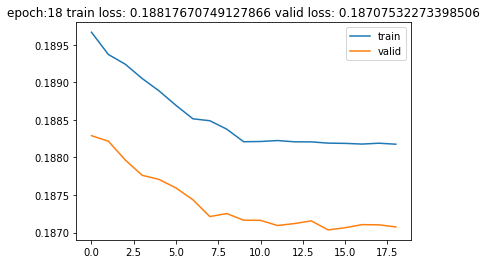

shouldTrain True shouldPrint False


KeyboardInterrupt: 

In [56]:

dec = 0.5
cec = 0.5
y = 0.5


epoch_num = 100

loss_function_dice = DiceLoss()
loss_function_ce = FocalLoss(y)

# lr = 1e-3
# epoch_num = 15
# optimizer = torch.optim.Adam(binarizer.parameters(), lr)
# folderToDumpFreeze = folderToDump + "freezedBackBone/"
# train(train_dataLoader, valid_dataLoader, binarizer, optimizer, loss_function_ce, loss_function_dice,\
#       epoch_num, folderToDumpFreeze, learningRate=lr, freezeFunc= freezeBackBone, reduceLR=[7,10], \
#       coefs = {"Dice":dec, "CE":cec, "Gamma":y})
#modelPath = folderToDumpFreeze + "14"
#binarizer.load_state_dict(torch.load(modelPath))


epoch_num = 50
lr = 1e-6
optimizer = torch.optim.Adam(binarizer.parameters(), lr)

folderToDumpBinarization = folderToDump + "binarization"
binarizer.load_state_dict(torch.load(folderToDump + "binarization\Dice0.5CE0.5Gamma0.5" + "/1"))
train(train_dataLoader, valid_dataLoader, binarizer, optimizer, loss_function_ce, loss_function_dice,\
      epoch_num, folderToDumpBinarization, learningRate=lr, freezeFunc= unfreezeAll, reduceLR=[10,20,35], \
      coefs = {"Dice":dec, "CE":cec, "Gamma":y})

In [43]:
dadsadsa

NameError: name 'dadsadsa' is not defined

In [44]:
value = 0.5
DiceCoeffs = [1, 2, 0.5, 5, 0.5]
CECoeffs = [  1, 1, 1,  0.5, 5]
Gamma = [0.5, 2, 5, 10]
len(DiceCoeffs) * len(Gamma)

20

In [45]:
# for y in Gamma:
#     for dec in DiceCoeffs:
#         for cec in CECoeffs:
            

#             lr = 1e-5
#             epoch_num = 25
#             #dec = 0.5
#             #cec = 0.5
#             optimizer = torch.optim.Adam(binarizer.parameters(), lr)
#             loss_function_dice = DiceLoss()
#             loss_function_ce = FocalLoss(y)

# #             folderToDumpFreeze = folderToDump + "freezedBackBone/"
# #             modelPath = folderToDumpFreeze + "14"
# #             binarizer.load_state_dict(torch.load(modelPath))
#             folderToDumpBinarization = folderToDump + "binarizationNoAug2"
#             train(train_dataLoader, valid_dataLoader, binarizer, optimizer, loss_function_ce, loss_function_dice,\
#                   epoch_num, folderToDumpBinarization, learningRate=lr, freezeFunc= unfreezeAll, reduceLR=[8,15,20], \
#                   coefs = {"Dice":dec, "CE":cec, "Gamma":y})
#         #    break
#       #  break
#     #break

In [46]:
assa

NameError: name 'assa' is not defined

In [47]:
def calcIOU(dataloader, net):
    with torch.no_grad():
        net.eval()
        ious = []
        progress = tn(dataloader)
        for i, data in enumerate(progress):
            distortedImage, gtImage, annotation = data
            distortedImage = distortedImage.cuda()
            gtImage = gtImage.cuda()

            binLogits, binClasses, _ = net(distortedImage)
            #binClasses = binClasses.squeeze()
            iou = countIOU(binClasses[0].detach().cpu().squeeze().numpy(), gtImage[0].detach().cpu().squeeze().numpy())
            ious.append(iou)
            progress.set_description("iou: %f.3" % np.mean(ious))
            if i % 10 == 0:
                s = 5
                plt.figure(figsize=(s,s))
                plt.imshow(distortedImage[0].detach().squeeze().cpu().numpy().transpose(1,2,0))
                plt.show()
                plt.figure(figsize=(s,s))
                plt.imshow(binClasses[0].detach().squeeze().cpu().numpy(), cmap="binary")
                plt.show()
                plt.figure(figsize=(s,s))
                plt.imshow(gtImage[0].detach().cpu().squeeze().numpy(), cmap="binary")
                plt.show()
    return np.mean(ious)


In [ ]:
ious = []
coefss = []
for y in Gamma:
    for dec in DiceCoeffs:
        for cec in CECoeffs:
            

            coefs = {"Dice":dec, "CE":cec, "Gamma":y}

#             folderToDumpFreeze = folderToDump + "freezedBackBone/"
#             modelPath = folderToDumpFreeze + "14"
#             binarizer.load_state_dict(torch.load(modelPath))
            folderToDumpBinarization = folderToDump + "binarizationNoAug2/"
            for item in coefs.items():
                folderToDumpBinarization += item[0] + str(item[1])
                
            if not os.path.exists(folderToDumpBinarization):
                continue
            #print("!")

            modelPath = folderToDumpBinarization + "/24"
            binarizer.load_state_dict(torch.load(modelPath))
            
            iou = calcIOU(valid_dataLoader, binarizer)
            ious.append(iou)
            coefss.append(coefs)

In [ ]:
ious

In [ ]:
coefss

In [58]:
folderToDumpBinarization = folderToDump + "binarization\Dice0.5CE0.5Gamma0.5"
modelPath = folderToDumpBinarization + "/18"
binarizer.load_state_dict(torch.load(modelPath))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.8195199505661132


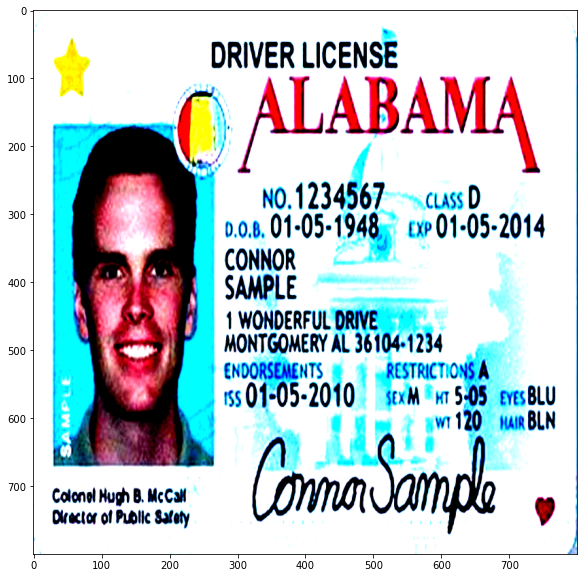

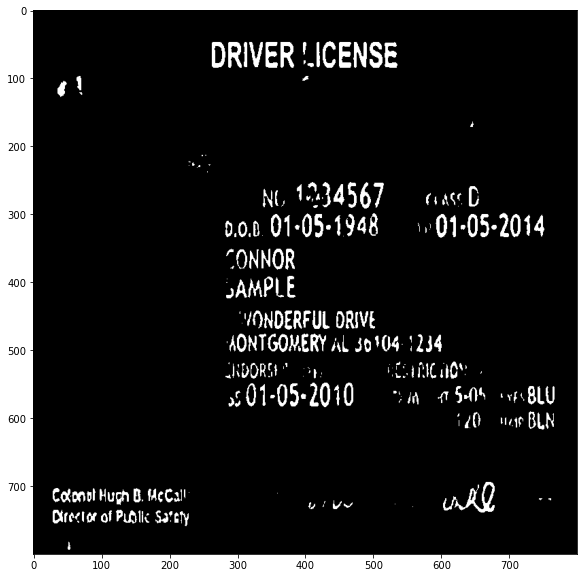

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.7824283118436036


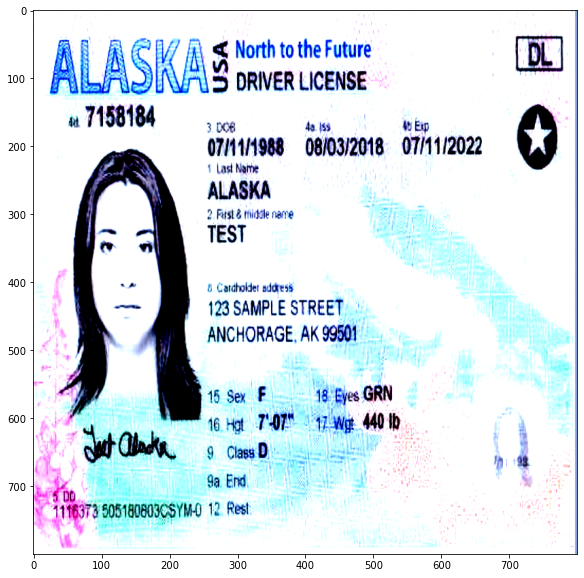

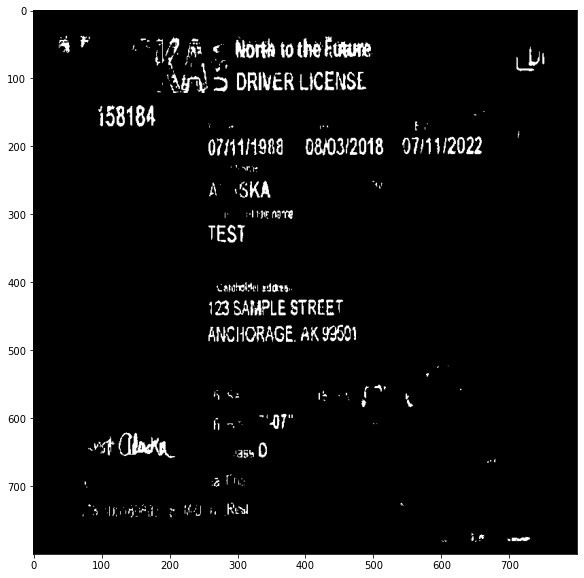

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.8071507594755782


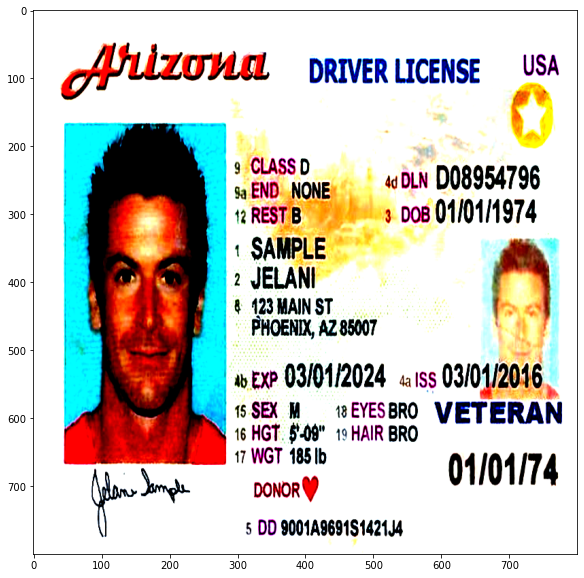

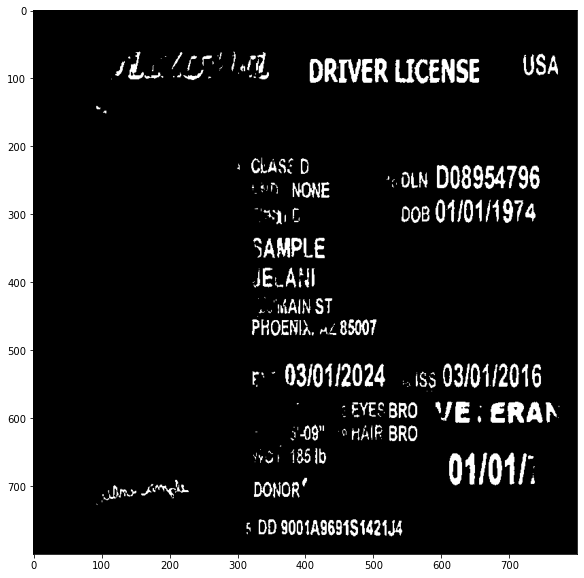

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.8540925618206368


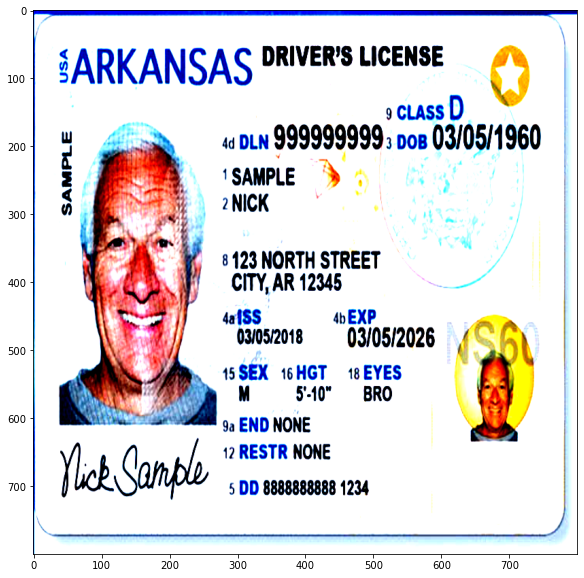

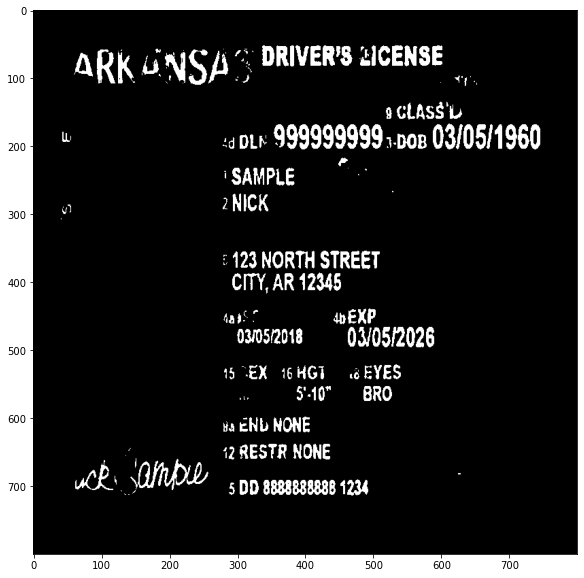

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.8319715524177346


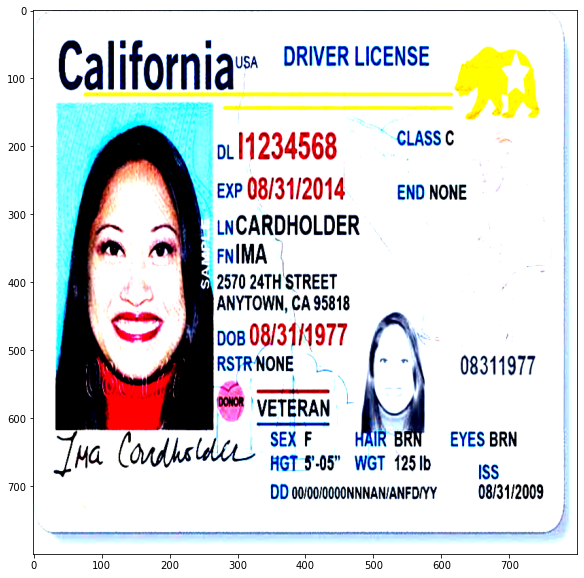

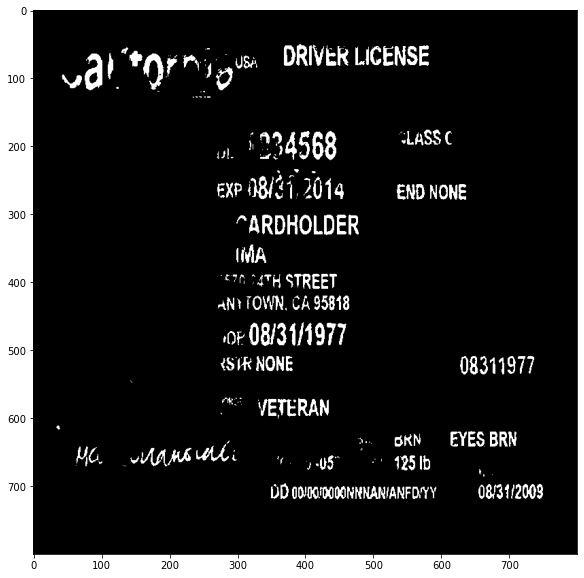

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.809607231754858


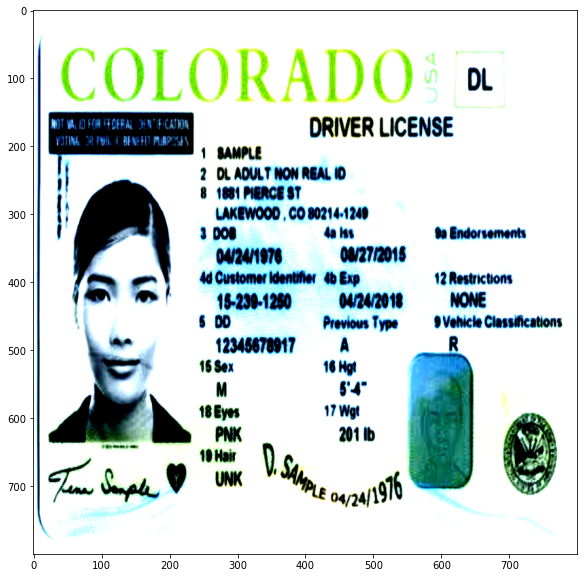

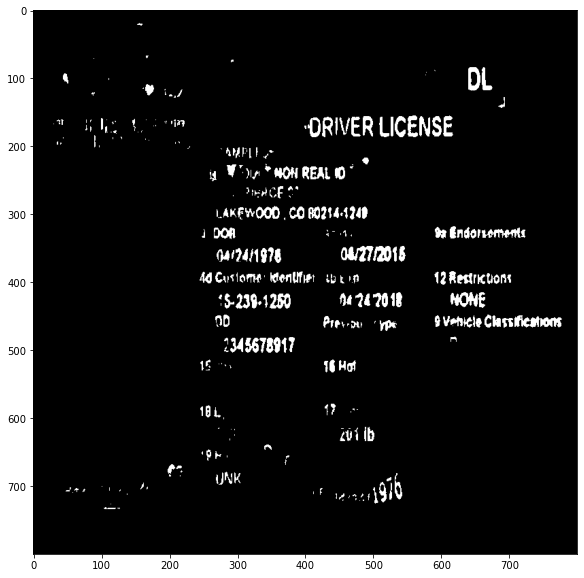

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.8354488375357828


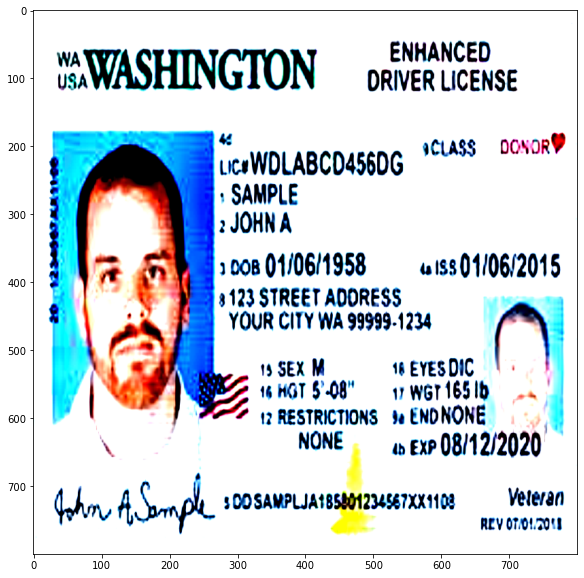

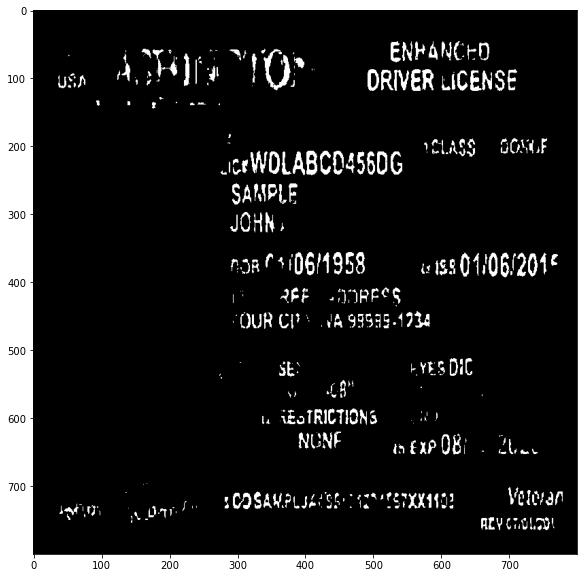

In [59]:
pathToRealImages = R"D:\Data\Diploma\real\real\realInternet//"
#pathToRealImages = R"D:\Data\Diploma\real\real\real\ARIZONAphotoUber12_all"
for imName in os.listdir(pathToRealImages):
    if "jpg" not in imName:
        continue
    try:
        realImage = PIL.Image.open(os.path.join(pathToRealImages, imName))
    except:
        continue
    realImage, ratio = ResizeMinSide()(realImage)

    realImage = realImage.convert('RGB')

    realImage = transf(realImage)


    with torch.no_grad():
        realImage = realImage.cuda()
        realImage = realImage.unsqueeze(0)
        binLogits, binClasses, _ = binarizer(realImage)
        #binClasses = binClasses.squeeze()
        iou = countIOU(binClasses[0].detach().cpu().squeeze().numpy(), realImage[0].detach().cpu().squeeze().numpy())
        print(iou)
        s = 10
        plt.figure(figsize=(s,s))
        plt.imshow(realImage[0].detach().squeeze().cpu().numpy().transpose(1,2,0))
        plt.show()
        plt.figure(figsize=(s,s))
        plt.imshow(binClasses[0].detach().squeeze().cpu().numpy(), cmap="binary")
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.8191426922527882


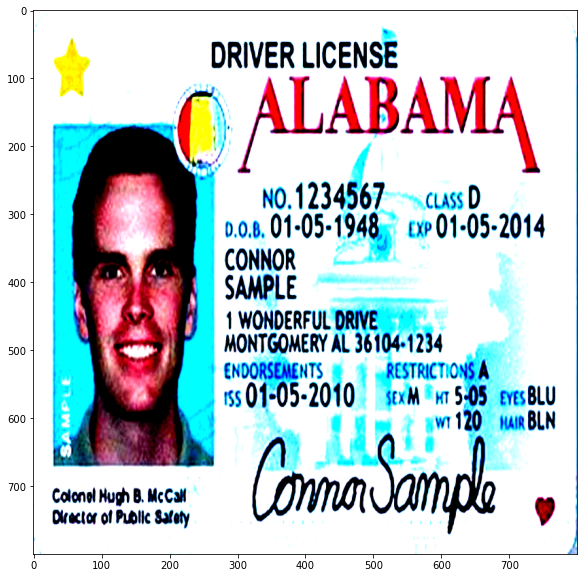

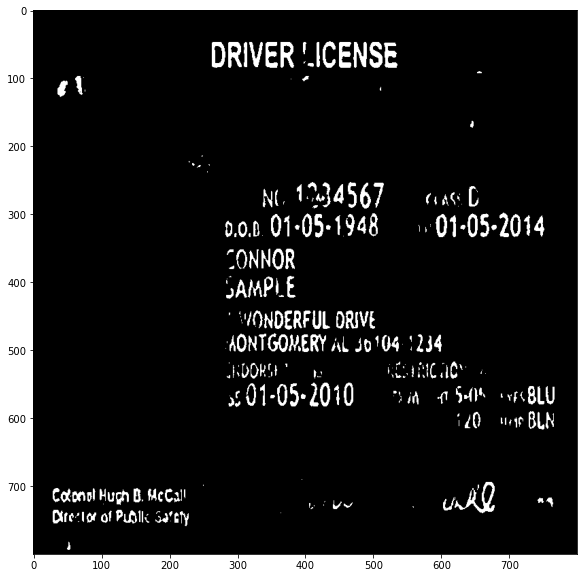

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.7822172985969693


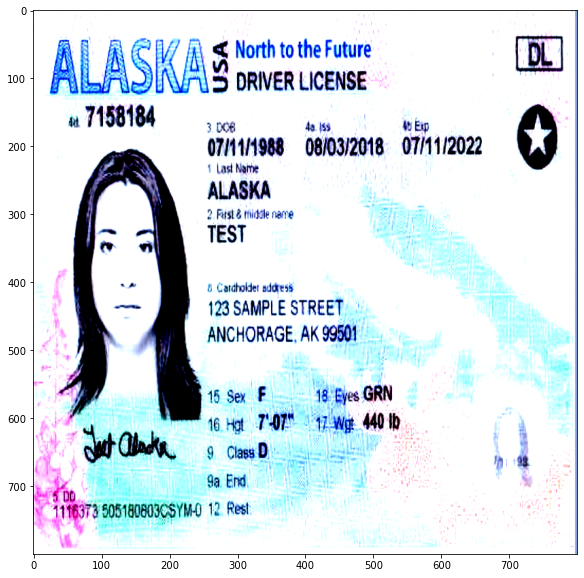

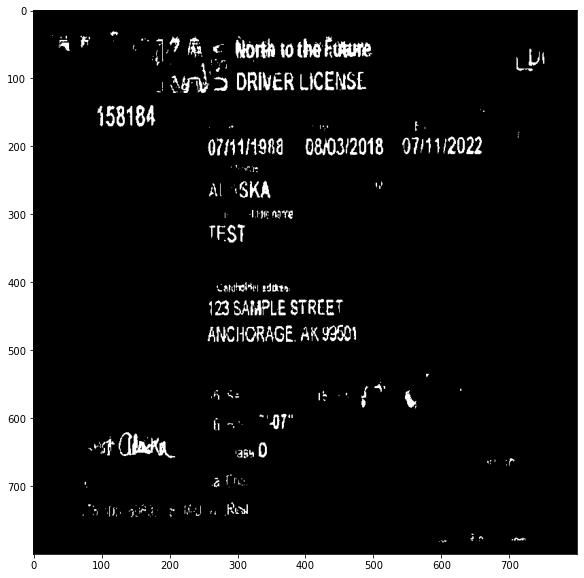

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.8061938703639847


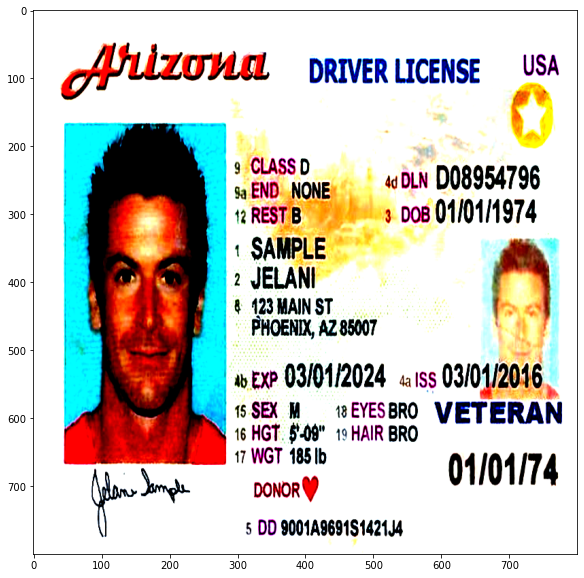

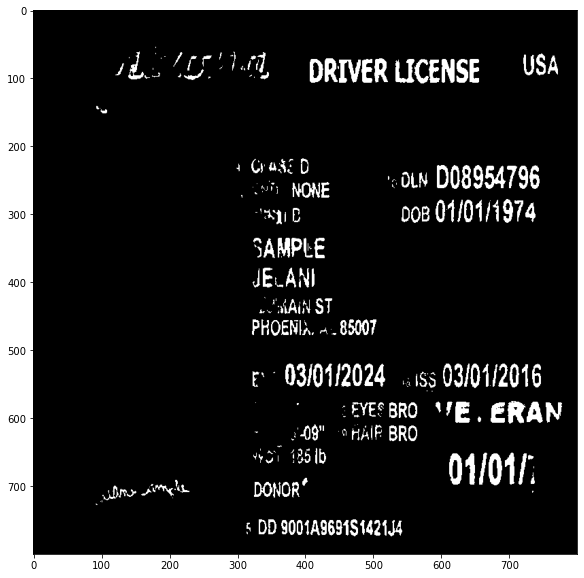

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.8530700706097795


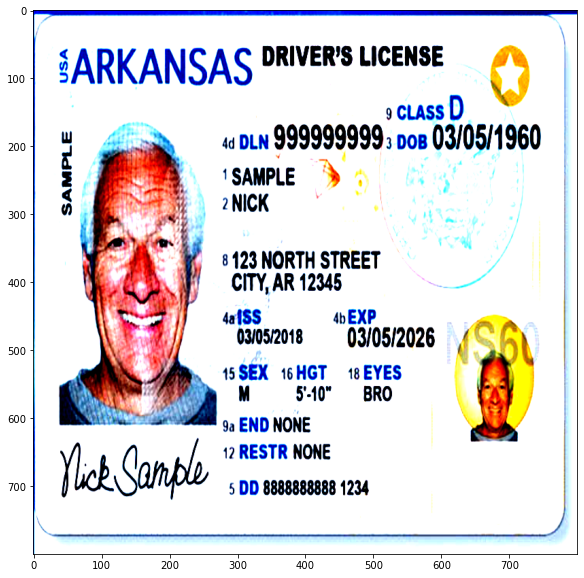

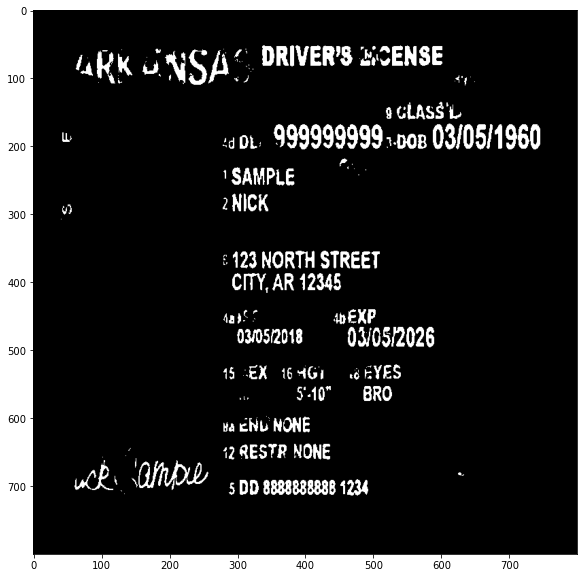

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.8309397405831707


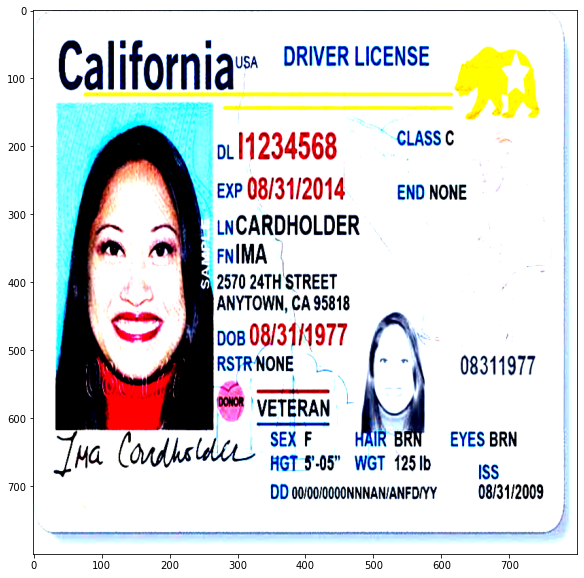

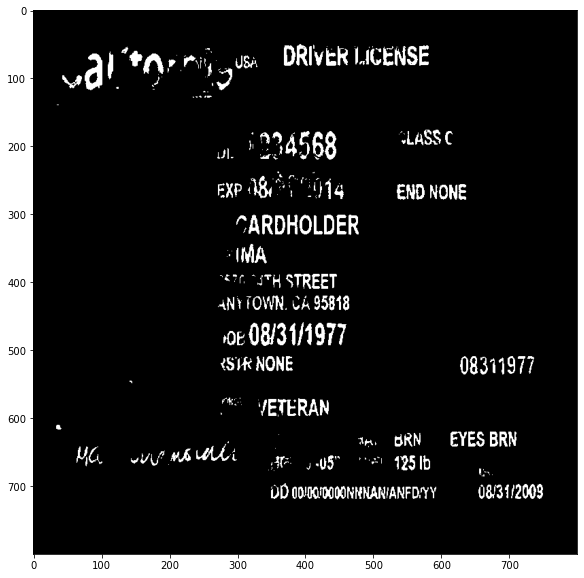

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.8091359535773986


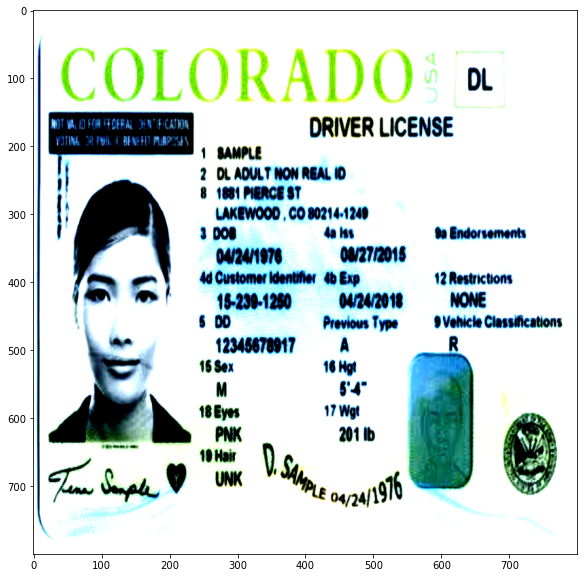

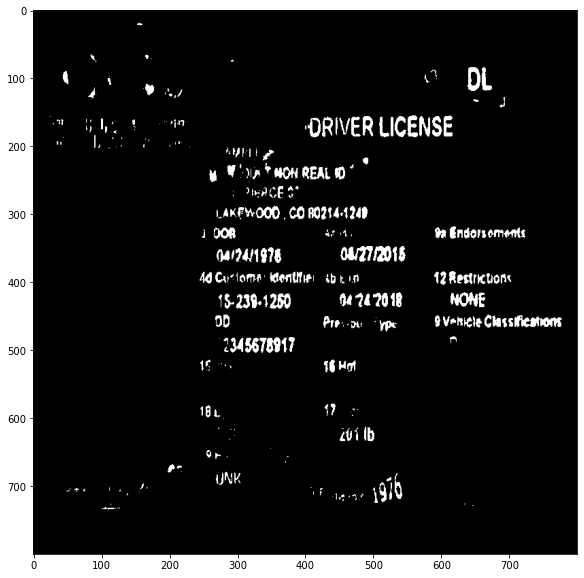

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.8347002367587003


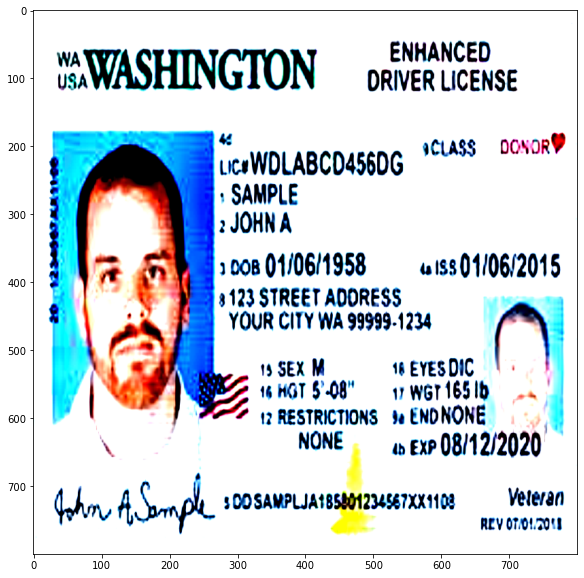

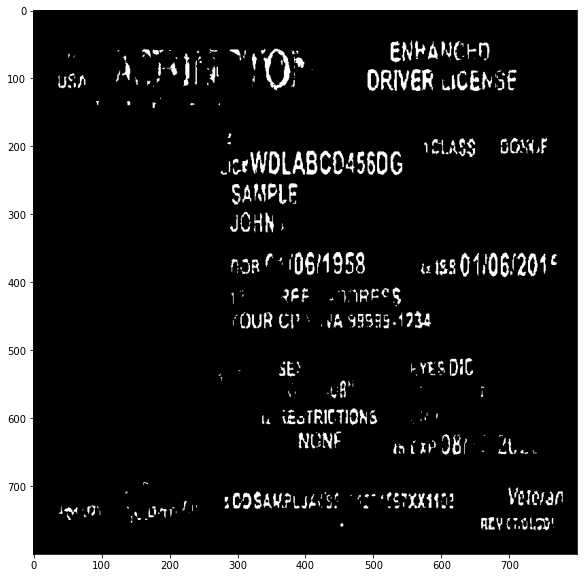

In [60]:
folderToDumpBinarization = folderToDump + "binarization\Dice0.5CE0.5Gamma0.5"
modelPath = folderToDumpBinarization + "/1"
binarizer.load_state_dict(torch.load(modelPath))

pathToRealImages = R"D:\Data\Diploma\real\real\realInternet//"
#pathToRealImages = R"D:\Data\Diploma\real\real\real\ARIZONAphotoUber12_all"
for imName in os.listdir(pathToRealImages):
    if "jpg" not in imName:
        continue
    try:
        realImage = PIL.Image.open(os.path.join(pathToRealImages, imName))
    except:
        continue
    realImage, ratio = ResizeMinSide()(realImage)

    realImage = realImage.convert('RGB')

    realImage = transf(realImage)


    with torch.no_grad():
        realImage = realImage.cuda()
        realImage = realImage.unsqueeze(0)
        binLogits, binClasses, _ = binarizer(realImage)
        #binClasses = binClasses.squeeze()
        iou = countIOU(binClasses[0].detach().cpu().squeeze().numpy(), realImage[0].detach().cpu().squeeze().numpy())
        print(iou)
        s = 10
        plt.figure(figsize=(s,s))
        plt.imshow(realImage[0].detach().squeeze().cpu().numpy().transpose(1,2,0))
        plt.show()
        plt.figure(figsize=(s,s))
        plt.imshow(binClasses[0].detach().squeeze().cpu().numpy(), cmap="binary")
        plt.show()

In [ ]:
calcIOU(test_daraLoader, binarizer)

In [ ]:
# binarizer = Binarizer().cuda()
# textDetector = generateFastRCNNModel(nn.Sequential(*list(binarizer.backbonep1), *list(binarizer.backbonep2), *list(binarizer.backbonep3), *list(Binarizer().backbonep4)))
# #textDetector = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True) #num_classes=1, pretrained_backbone=True) #generateFastRCNNModel(nn.Sequential(*list(binarizer.backbonep1), *list(binarizer.backbonep2), *list(binarizer.backbonep3), *list(Binarizer().backbonep4)))

In [ ]:
lr = 1e-3
epoch_num = 15
optimizer = torch.optim.Adam(binarizer.parameters(), lr)
loss_function_dice = DiceLoss()#nn.CrossEntropyLoss()
loss_function_ce = FocalLoss()#nn.CrossEntropyLoss()

In [ ]:
# folderToDumpSyn = pathToDiplomaData + "dumpSyn/"
# modelPath = folderToDumpSyn + "1"

# folderToDumpSyn =  folderToDump + "_DetectionFreeze"+"/" + str(0)
# modelPath = folderToDumpSyn

# binarizer.load_state_dict(torch.load(modelPath))
# trainDetectionFreezed(dataLoader, syntheticDataset, binarizer, textDetector,optimizer, loss_function_ce, loss_function_dice, epoch_num, lr)

In [ ]:
lr = 0.00001
epoch_num = 15
optimizer = torch.optim.Adam(binarizer.parameters(), lr)
loss_function_dice = DiceLoss()#nn.CrossEntropyLoss()
loss_function_ce = FocalLoss()#nn.CrossEntropyLoss()

In [ ]:
# os.makedirs(folderToDump, exist_ok=True)
# torch.save(binarizer.state_dict(), folderToDump+"/" + str(0))
# torch.save(textDetector.state_dict(), folderToDump + "/" + str(0)+"detectionNet")

In [ ]:
folderToDumpFreeze = pathToDiplomaData + "dumpsDetection/"
modelPath = folderToDumpFreeze + "5"
binarizer.load_state_dict(torch.load(modelPath))
textDetector.load_state_dict(torch.load(modelPath+"detectionNet"))
trainDetection(dataLoader, syntheticDataset, binarizer, textDetector,optimizer, loss_function_ce, loss_function_dice, epoch_num, lr, 0)

In [ ]:
folderToDumpFreeze = pathToDiplomaData + "dumpsDetection/"
modelPath = folderToDumpFreeze + "4"
binarizer.load_state_dict(torch.load(modelPath))
textDetector.load_state_dict(torch.load(modelPath+"detectionNet"))
trainDetection(dataLoader, syntheticDataset, binarizer, textDetector,optimizer, loss_function_ce, loss_function_dice, epoch_num, lr, 0)

In [ ]:
#TODO FOCAL LOSSS!!!!!!!